In [1]:
# Import python libraries
#
import importlib
import pickle
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import scripts.Model as model
import scripts.ModelAdapter as ModelAdapter


/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/home/molu/miniconda3/envs/xlstm'


In [2]:
importlib.reload(model)
importlib.reload(Simulation_config)
importlib.reload(utils)

# Print the sumarized simulation results
#
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')
result_dict


defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>()>,
            {'median': defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>.<locals>.<lambda>()>,
                         {0: defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'SyntheticLoadProfile': '33.24',
                                       'KNN': '16.89',
                                       'PersistencePrediction': '14.27',
                                       'xLSTM': '12.38',
                                       'LSTM': '12.63',
                                       'Transformer': '12.68'}),
                          1: defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'SyntheticLoadProfile': '39.66',
                           

In [3]:
# Store specific predictions, for the paper 'use case' section.
#

importlib.reload(model)
importlib.reload(utils)
importlib.reload(ModelTrainer)

# Define a specific configuration
#
myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._37_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._15_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                            train_size = myConfig.trainingHistory,
                                            test_size = modelTrainer.test_set_size_days, 
                                            prediction_history = myConfig.modelInputHistory,
                                            )
community_id = 0  # chose one of many energy communites
X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
path_to_trained_parameters = 'scripts/outputs/all_trained_models_20241107_0520.pth'
num_of_features = X['train'].shape[2]
P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

# Store the predicted power profiles
#
for model_type in Simulation_config.UsedModels.ALL:
    test_profile = f"scripts/outputs/file_{community_id}.pkl"
    my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
    Y_pred = torch.Tensor(modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).flatten())
    P_el_predicted = torch.cat([P_el_predicted, Y_pred.unsqueeze(0)], dim=0)    

startdate = modelAdapter.getStartDateFromIndex('test', 0)
file_path = "scripts/outputs/example_predictions.pkl"
with open(file_path, 'wb') as file:
    pickle.dump((P_el_predicted, startdate), file)

print(P_el_predicted.shape)
print(startdate)


torch.Size([7, 3144])
2013-10-20 00:00:00+00:00


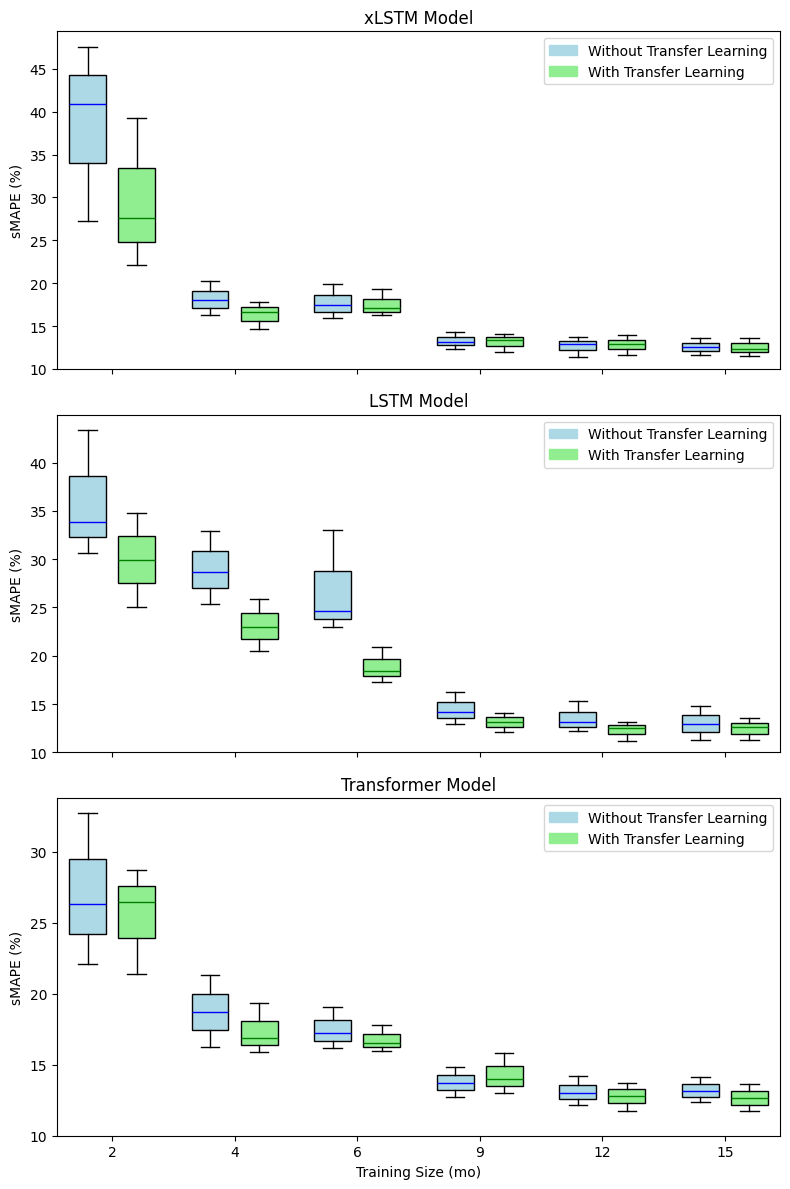

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

# Constants and Configuration
models = ['xLSTM', 'LSTM', 'Transformer']
training_sizes = ['2', '4', '6', '9', '12', '15']
configs_with_transfer = [*range(2, 7), 0]
configs_without_transfer = [*range(9, 14), 7]

# Helper function to retrieve and format selected data
def get_selected_list(metric, model, configs, result_dict):
    return pd.DataFrame(result_dict[metric], dtype=float).loc[model, configs]

# Function to create DataFrames for each transfer type
def create_transfer_df(configs, training_sizes, result_dict):
    data = {
        'Training Size (mo)': training_sizes
    }
    for model in models:
        data[model] = get_selected_list('median', model, configs, result_dict)
        data[f'{model} first quartil'] = get_selected_list('first quartil', model, configs, result_dict)
        data[f'{model} third quartil'] = get_selected_list('third quartil', model, configs, result_dict)
    return pd.DataFrame(data)

# Creating DataFrames for both cases
df_with_transfer = create_transfer_df(configs_with_transfer, training_sizes, result_dict)
df_without_transfer = create_transfer_df(configs_without_transfer, training_sizes, result_dict)

# Creating subplots for boxplots
fig, axes = plt.subplots(len(models), 1, figsize=(8, 12), sharex=True)

# Define legend patches for the legend
legend_patches = [
    Patch(color="lightblue", label="Without Transfer Learning"),
    Patch(color="lightgreen", label="With Transfer Learning")
]

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Prepare data for boxplot
    data_without_transfer = [df_without_transfer[[model, f'{model} first quartil', f'{model} third quartil']].values[i, :] 
                             for i in range(len(training_sizes))]
    data_with_transfer = [df_with_transfer[[model, f'{model} first quartil', f'{model} third quartil']].values[i, :] 
                          for i in range(len(training_sizes))]
    
    # Create boxplots for without and with transfer data
    ax.boxplot(data_without_transfer, positions=np.array(range(len(training_sizes)))*2.0 - 0.4, widths=0.6, 
               patch_artist=True, boxprops=dict(facecolor="lightblue"), medianprops=dict(color="blue"), 
               flierprops=dict(markerfacecolor='blue', marker='o'))
    ax.boxplot(data_with_transfer, positions=np.array(range(len(training_sizes)))*2.0 + 0.4, widths=0.6, 
               patch_artist=True, boxprops=dict(facecolor="lightgreen"), medianprops=dict(color="green"), 
               flierprops=dict(markerfacecolor='green', marker='o'))
    
    # Labels and title
    ax.set_ylabel('sMAPE (%)')
    ax.set_title(f"{model} Model")
    ax.set_xticks(np.array(range(len(training_sizes)))*2.0)
    ax.set_xticklabels(training_sizes)
    
    # Set y-axis limits
    ax.set_ylim(10, None)
    
    # Add legend to each subplot
    ax.legend(handles=legend_patches, loc="upper right")

# Set x-axis label for the last plot
axes[-1].set_xlabel('Training Size (mo)')
plt.tight_layout()
plt.show()
